# Instalación de EasyOCR

Este proyecto usa **EasyOCR** para reconocimiento óptico de caracteres.

## Instalación:

```bash
pip install easyocr
```

## Ventajas de EasyOCR:
- ✅ No requiere instalación externa (todo es Python)
- ✅ Muy preciso con fuentes variadas
- ✅ Excelente manejo de texto con fondos complejos
- ✅ Soporte para GPU (opcional, pero funciona bien en CPU)
- ✅ Soporte multiidioma (inglés, japonés, etc.)
- ✅ Fácil de usar y configurar

**Nota:** La primera vez que se ejecute, EasyOCR descargará automáticamente los modelos necesarios (~150MB).

In [27]:
# Ejecuta esta celda para verificar si EasyOCR está instalado

import sys
import subprocess

print("🔍 Verificando EasyOCR...\n")

try:
    import easyocr
    print("✅ EasyOCR está instalado y listo para usar!")
except ImportError:
    print("❌ EasyOCR no está instalado")
    print("\n💡 Para instalarlo, usa el terminal:")
    print("   pip install easyocr")
    print("\n⚠️  Después de instalar, REINICIA EL KERNEL del notebook")


🔍 Verificando EasyOCR...

✅ EasyOCR está instalado y listo para usar!


In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import easyocr

# Inicializar EasyOCR una sola vez (en inglés)
reader = easyocr.Reader(['en'], gpu=False)  # gpu=True si tienes GPU NVIDIA
print("✅ EasyOCR inicializado y listo para usar")

matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)

images_path = './Images/'
images_path_english = './Images/English/'
images_path_japanese = './Images/Japanese/'


Using CPU. Note: This module is much faster with a GPU.


✅ EasyOCR inicializado y listo para usar


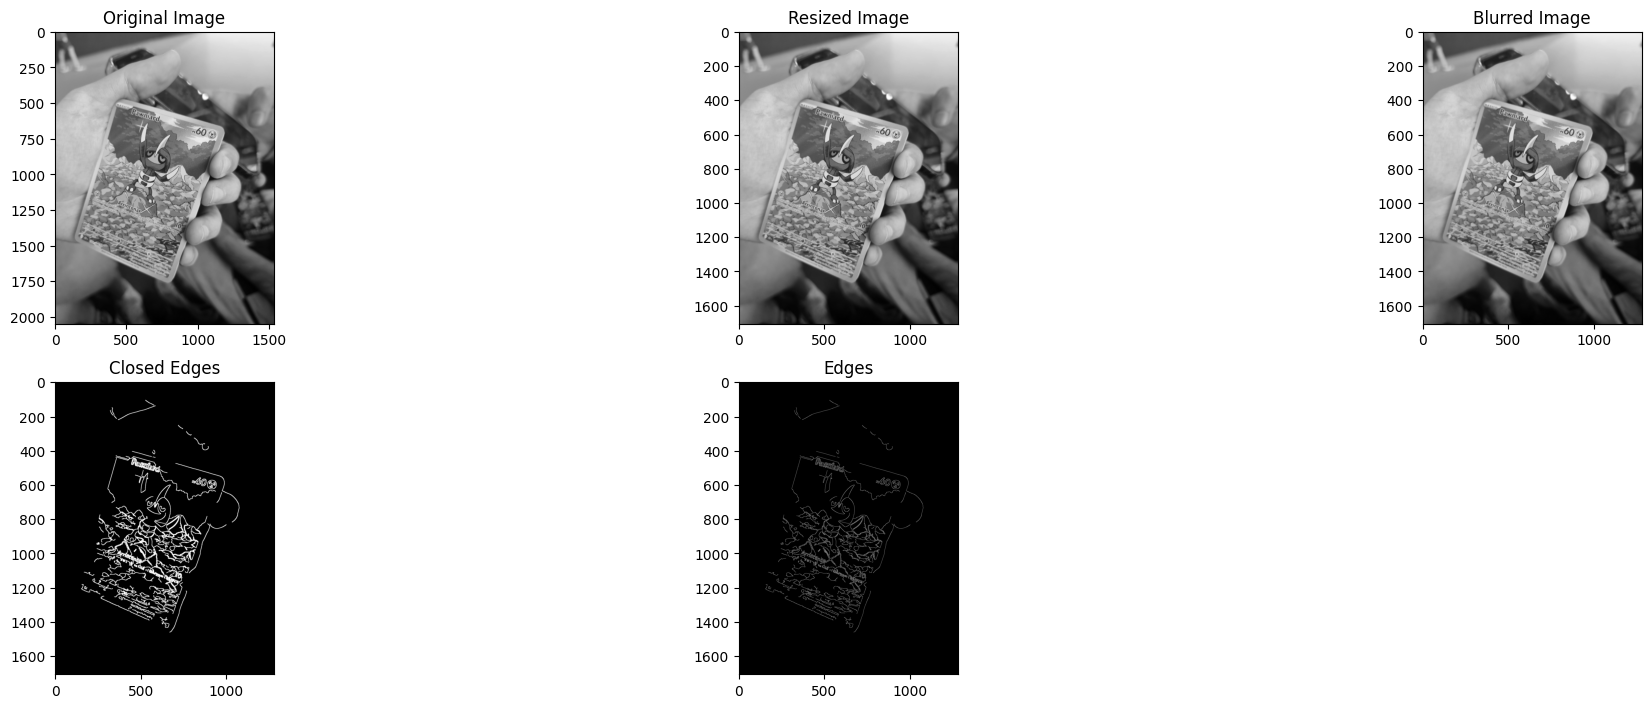

In [31]:
base_image = cv2.imread(images_path_english + 'English_27.jpg',0)
img_resized = cv2.resize(base_image, (1280, int(base_image.shape[0] * 1280/base_image.shape[1])))  # para trabajar siempre a escala similar
img_blur = cv2.GaussianBlur(img_resized, (5,5), 1.0)
edges = cv2.Canny(img_blur, 75, 200)
kernel = np.ones((3,3), np.uint8)
edges_closed = cv2.dilate(edges, kernel, iterations=1)
cnts, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)


plt.figure(figsize=(25, 22))  # (ancho, alto) en pulgadas

plt.subplot(5, 3, 1)
plt.imshow(base_image, cmap='gray')
plt.title('Original Image')

plt.subplot(5, 3, 2)
plt.imshow(img_resized, cmap='gray')
plt.title('Resized Image')

plt.subplot(5, 3, 3)
plt.imshow(img_blur, cmap='gray')
plt.title('Blurred Image')

plt.subplot(5, 3, 4)
plt.imshow(edges_closed, cmap='gray')
plt.title('Closed Edges')

plt.subplot(5, 3, 5)
plt.imshow(edges, cmap='gray')
plt.title('Edges')

plt.show()


In [32]:
import cv2
import numpy as np


# ------------------------------------------------------------
# 1. Cargar y preprocesar
# ------------------------------------------------------------
def cargar_y_preprocesar(ruta_img, ancho_max=1280):
    img = cv2.imread(ruta_img)
    if img is None:
        raise ValueError("No se pudo leer la imagen. Revisa la ruta.")

	# Ponemos un ancho común y hacemos que el alto se ajuste
    height, width = img.shape[:2]
    if width > ancho_max:
        escalawidth = ancho_max / width
        nuevoheight = int(height * escalawidth)
        img = cv2.resize(img, (ancho_max, nuevoheight))

    # Uso Canny para detectar los bordes
    img_blur = cv2.GaussianBlur(img, (5, 5), 1)
    img_gray = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(img_gray, 75, 200)

    # Dilato los bordes para unirlos
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=2)
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)

    return img, img_gray, edges



# ------------------------------------------------------------
# 2B. Contornos (fallback)
# ------------------------------------------------------------
def encontrar_carta_como_quad(edges, margen_borde=6):
    h, w = edges.shape[:2]

    cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    candidatos = []
    for c in cnts:
        area = cv2.contourArea(c)
        
		# Si el contorno es muy pequeño, lo descartamos
        if area < 100000:
            continue

		# Si el contorno toca los bordes de la imagen, lo descartamos
        pts = c.reshape(-1, 2)
        if (
            np.any(pts[:, 0] <= margen_borde)
            or np.any(pts[:, 1] <= margen_borde)
            or np.any(pts[:, 0] >= w - margen_borde)
            or np.any(pts[:, 1] >= h - margen_borde)
        ):
            continue

        # Calculamos el rectángulo mínimo que encierra el contorno
        rect = cv2.minAreaRect(c)
        
		# Descartamos lineas
        (wr, hr) = rect[1]
        if wr == 0 or hr == 0:
            continue

        candidatos.append((area, rect))

    if not candidatos:
        return None

	# Busco el rectángulo con mayor área
    candidatos.sort(key=lambda x: x[0], reverse=True)
    
	# Retorno las coordenadas del rectángulo
    area, rect = candidatos[0]
    #print(f"Area: {area}")
    box = cv2.boxPoints(rect)
    return box



# ------------------------------------------------------------
# Ordenar y rectificar
# ------------------------------------------------------------
def ordenar_puntos(pts):
    """Ordenar puntos: [top-left, top-right, bottom-right, bottom-left]"""
    pts = np.array(pts, dtype=np.float32)
    
    # Ordenar por X
    sorted_x = pts[np.argsort(pts[:, 0])]
    
    # Dividir: izquierda (2 primeros) y derecha (2 últimos)
    izq = sorted_x[:2]
    der = sorted_x[2:]
    
    # Ordenar cada lado por Y (arriba → abajo)
    izq = izq[np.argsort(izq[:, 1])]
    der = der[np.argsort(der[:, 1])]
    
    # Devolver en orden: tl, tr, br, bl
    return np.array([izq[0], der[0], der[1], izq[1]], dtype=np.float32)


def rectificar_carta(img_color, pts_src, ancho_dest=720):
    """Versión simplificada con ordenamiento correcto"""
    alto_dest = int(ancho_dest / 0.715)
    
    # Ordenamos los puntos antes de la homografía
    pts_src = ordenar_puntos(pts_src)
    
    # Puntos destino en el MISMO orden
    pts_dst = np.float32([
        [0, 0],                  # top-left
        [ancho_dest, 0],         # top-right
        [ancho_dest, alto_dest], # bottom-right
        [0, alto_dest]           # bottom-left
    ])
    
    # Calcular homografía y rectificar
    M = cv2.getPerspectiveTransform(pts_src, pts_dst)
    warped = cv2.warpPerspective(img_color, M, (ancho_dest, alto_dest))
    
    return warped


# ------------------------------------------------------------
# Mostrar reducido
# ------------------------------------------------------------
def mostrar_redimensionada(win_name, img, ancho_max=900, alto_max=700):
    """Muestra imagen usando matplotlib (compatible con notebooks)"""
    h, w = img.shape[:2]
    escala = min(ancho_max / w, alto_max / h, 1.0)
    img_small = cv2.resize(img, (int(w * escala), int(h * escala)))
    
    # Convertir BGR a RGB si es imagen a color
    if len(img_small.shape) == 3:
        img_display = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
    else:
        img_display = img_small
    
    # Mostrar con matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(img_display, cmap='gray' if len(img_small.shape) == 2 else None)
    plt.title(win_name)
    plt.axis('off')
    plt.show()

def extraer_rois_carta(carta_rectificada):
    """Extrae las regiones donde está el nombre, HP y número"""
    h, w = carta_rectificada.shape[:2]
    
    # Región del NOMBRE (arriba izquierda) - Ajustada para mejor captura
    name_roi = carta_rectificada[
        int(0.0 * h) : int(0.12 * h),  # Y: 2% al 5.5% altura (más centrado)
        int(0. * w) : int(0.65 * w)     # X: 6% al 50% ancho (más amplio)
    ]
    
    # Región del HP (arriba derecha) - Ajustada para capturar solo los números
    hp_roi = carta_rectificada[
        int(0.0 * h) : int(0.12 * h),  # Y: 5.5% al 9.5% altura (igual que nombre)
        int(0.68 * w) : int(1 * w)     # X: 68% al 90% ancho (más ajustado)
    ]
    
    # Región del NÚMERO (abajo derecha, esquina)
    numero_roi = carta_rectificada[
        int(0.9 * h) : int(1 * h),  # Y: 93% al 99% altura
        int(0.01 * w) : int(0.35 * w)   # X: 75% al 95% ancho
    ]
    
    return {
        "name": name_roi,
        "hp": hp_roi,
        "numero": numero_roi
    }



def preprocesar_roi_para_ocr(roi, tipo="text"):
    """
    Preprocesar ROI para mejorar OCR
    
    Args:
        roi: región de interés
        tipo: "text" para texto general, "number" para números
    
    Returns:
        ROI preprocesada
    """
    # Convertir a escala de grises si es necesario
    if len(roi.shape) == 3:
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    else:
        gray = roi.copy()
    
    # Redimensionar para mejorar OCR (escalar x3)
    h, w = gray.shape
    gray = cv2.resize(gray, (w * 3, h * 3), interpolation=cv2.INTER_CUBIC)
    
    # Aplicar desenfoque para reducir ruido
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Aumentar contraste con CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    
    if tipo == "number":
        # Para números: binarización más agresiva
        # Usar umbral adaptativo
        binary = cv2.adaptiveThreshold(
            gray, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            21, 10
        )
        
        # Dilatar ligeramente para unir caracteres fragmentados
        kernel = np.ones((2, 2), np.uint8)
        binary = cv2.dilate(binary, kernel, iterations=1)
        
        # Convertir de vuelta a BGR para EasyOCR
        result = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
    else:
        # Para texto: procesamiento más suave
        binary = cv2.adaptiveThreshold(
            gray, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            15, 5
        )
        result = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
    
    return result


def aplicar_ocr(roi, allowlist=None, paragraph=False):
    """
    Función para OCR usando EasyOCR
    
    Args:
        roi: región de interés (puede ser BGR o escala de grises)
        allowlist: caracteres permitidos (por ejemplo: "0123456789/" para números)
        paragraph: si True, trata el texto como párrafo
    
    Returns:
        texto extraído (string)
    """
    global reader
    
    # EasyOCR funciona mejor con imágenes en color
    if len(roi.shape) == 2:  # si es escala de grises
        roi_to_process = cv2.cvtColor(roi, cv2.COLOR_GRAY2BGR)
    else:
        roi_to_process = roi
    
    # Configurar parámetros de EasyOCR
    kwargs = {
        'detail': 0,  # Solo devolver texto
        'paragraph': paragraph
    }
    
    if allowlist:
        kwargs['allowlist'] = allowlist
    
    # EasyOCR devuelve lista de tuplas: (bbox, texto, confianza)
    resultado = reader.readtext(roi_to_process, **kwargs)
    texto = ' '.join(resultado) if resultado else ''
    
    return texto.strip()


def getNombre(carta):
    """Extraer nombre de la carta"""
    rois = extraer_rois_carta(carta)
    name_roi = rois["name"]
    
    # Preprocesar específicamente para texto
    name_roi_procesado = preprocesar_roi_para_ocr(name_roi, tipo="text")
    
    # Aplicar OCR con letras y espacios
    texto = aplicar_ocr(name_roi_procesado, allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz -')
    
    # Limpiar el resultado
    import re
    # Eliminar caracteres extraños y quedarnos solo con letras y espacios
    nombre = re.sub(r'[^A-Za-z\s-]', '', texto)
    nombre = ' '.join(nombre.split())  # normalizar espacios
    
    return nombre


def getHP(carta):
    """Extraer HP de la carta"""
    rois = extraer_rois_carta(carta)
    hp_roi = rois["hp"]
    
    # Preprocesar específicamente para números
    hp_roi_procesado = preprocesar_roi_para_ocr(hp_roi, tipo="number")
    
    # Aplicar OCR solo con números permitidos
    texto = aplicar_ocr(hp_roi_procesado, allowlist='0123456789HP ')
    
    # Extraer solo el número
    import re
    # Buscar números (puede tener "HP" antes)
    match = re.search(r'(\d+)', texto)
    if match:
        return match.group(1)
    
    # Si no encontró nada, devolver el texto limpio
    return re.sub(r'[^0-9]', '', texto)


def getNumero(carta):
    """Extraer número de la carta"""
    rois = extraer_rois_carta(carta)
    numero_roi = rois["numero"]
    
    # Preprocesar específicamente para números
    numero_roi_procesado = preprocesar_roi_para_ocr(numero_roi, tipo="number")
    
    # Aplicar OCR solo con números y barra permitidos
    texto = aplicar_ocr(numero_roi_procesado, allowlist='0123456789/')
    
    # Extraer solo números y /
    import re
    match = re.search(r'[\d/]+', texto)
    if match:
        return match.group(0)
    
    # Si no encontró nada, devolver el texto limpio
    return re.sub(r'[^0-9/]', '', texto)



In [ ]:
'''
ruta = images_path_english + "English_24.jpg"
ruta2 = images_path_japanese + "Japanese_1.jpg"

img_color, img_gray, edges = cargar_y_preprocesar(ruta)

# 2) detección por contornos
quad_cnt = encontrar_carta_como_quad(edges)

# --- dibujar contornos ---
img_cnt = img_color.copy()
if quad_cnt is not None:
    cv2.polylines(img_cnt, [quad_cnt.astype(int)], True, (255, 0, 0), 3)
else:
    cv2.putText(img_cnt, "Contornos no encontro carta", (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)

mostrar_redimensionada("Contornos", img_cnt)

# Mostramos la carta rectificada si se encontró
if quad_cnt is not None:
    carta = rectificar_carta(img_color, quad_cnt)
    #mostrar_redimensionada("Rectificada (Contorno)", carta)
    
    # Extraer y mostrar cada ROI individualmente
    rois = extraer_rois_carta(carta)

    plt.subplot(1,3,1)
    plt.imshow(rois["name"], cmap='gray')
    plt.title('ROI - Nombre')
    plt.subplot(1,3,2)
    plt.imshow(rois["hp"], cmap='gray')
    plt.title('ROI - HP')
    plt.subplot(1,3,3)
    plt.imshow(rois["numero"], cmap='gray')
    plt.title('ROI - Número')

# Extraer información con OCR

print("\n=== INFORMACIÓN EXTRAÍDA ===")
nombre = getNombre(carta)
print(f"Nombre: {nombre}")

hp = getHP(carta)
print(f"HP: {hp}")

numero = getNumero(carta)
print(f"Número: {numero}")
'''



'\nruta = images_path_english + "English_24.jpg"\nruta2 = images_path_japanese + "Japanese_1.jpg"\n\nimg_color, img_gray, edges = cargar_y_preprocesar(ruta)\n\n# 2) detección por contornos\nquad_cnt = encontrar_carta_como_quad(edges)\n\n# --- dibujar contornos ---\nimg_cnt = img_color.copy()\nif quad_cnt is not None:\n    cv2.polylines(img_cnt, [quad_cnt.astype(int)], True, (255, 0, 0), 3)\nelse:\n    cv2.putText(img_cnt, "Contornos no encontro carta", (20, 40),\n                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)\n\nmostrar_redimensionada("Contornos", img_cnt)\n\n# Mostramos la carta rectificada si se encontró\nif quad_cnt is not None:\n    carta = rectificar_carta(img_color, quad_cnt)\n    #mostrar_redimensionada("Rectificada (Contorno)", carta)\n\n    # Extraer y mostrar cada ROI individualmente\n    rois = extraer_rois_carta(carta)\n\n    plt.subplot(1,3,1)\n    plt.imshow(rois["name"], cmap=\'gray\')\n    plt.title(\'ROI - Nombre\')\n    plt.subplot(1,3,2)\n    plt.imsh

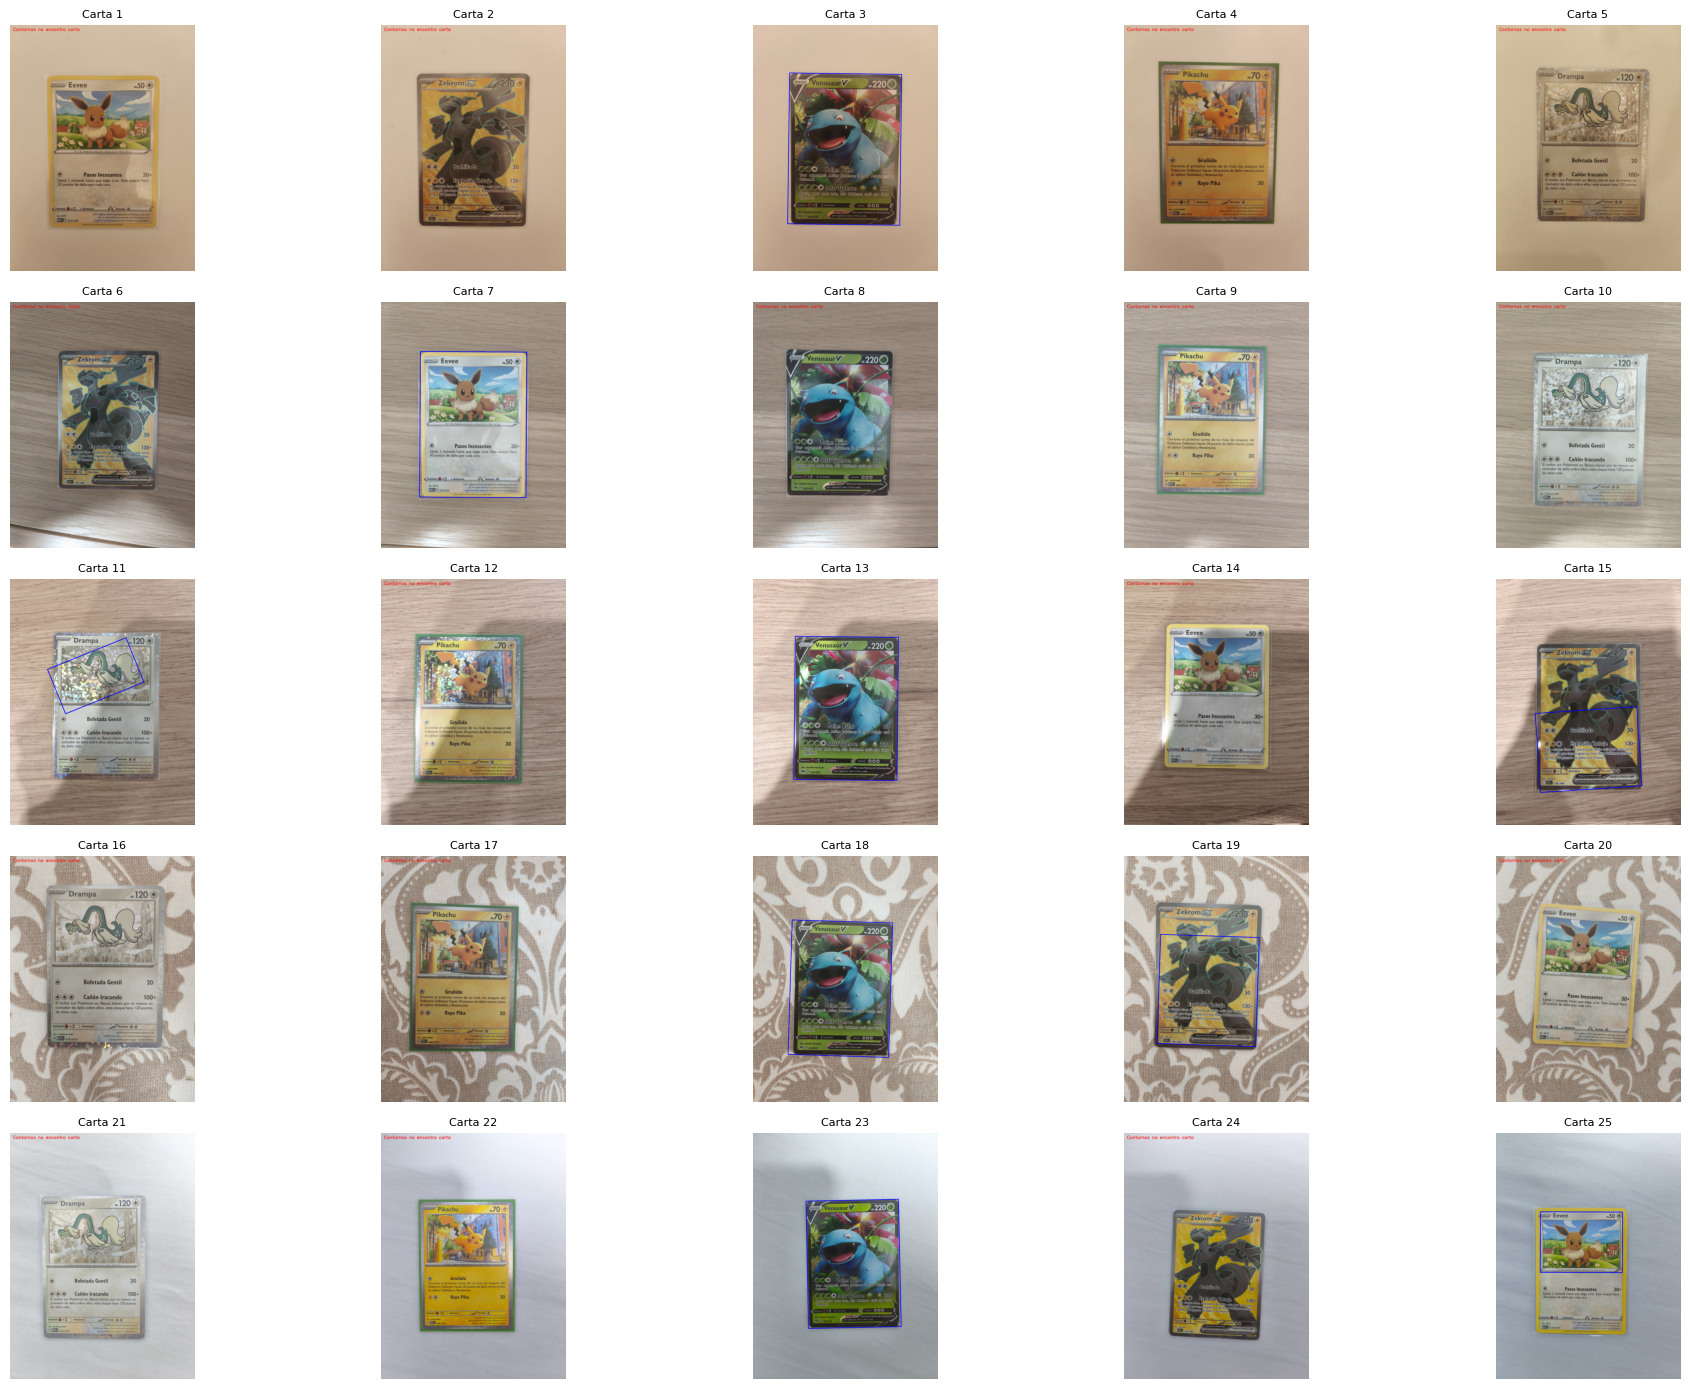

In [36]:
def cargarYDibujarContornos(index):
    ruta = images_path_english + "English_" + str(index) + ".jpg"
    ruta = images_path + "/Final/" + "Final_" + str(index) + ".jpg"

    img_color, img_gray, edges = cargar_y_preprocesar(ruta)

    # 2) detección por contornos
    quad_cnt = encontrar_carta_como_quad(edges)

    img_cnt = img_color.copy()
    if quad_cnt is not None:
        cv2.polylines(img_cnt, [quad_cnt.astype(int)], True, (255, 0, 0), 3)
    else:
        cv2.putText(img_cnt, "Contornos no encontro carta", (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)
        
    return img_cnt

# Crear una figura grande con todas las imágenes en matriz
num_imagenes = 25
filas = 5
columnas = 5

plt.figure(figsize=(20, 14))  # Tamaño grande para ver bien todas las cartas

for i in range(1, num_imagenes + 1):
    img_contornos = cargarYDibujarContornos(i)
    
    plt.subplot(filas, columnas, i)
    plt.imshow(cv2.cvtColor(img_contornos, cv2.COLOR_BGR2RGB))
    plt.title(f"Carta {i}", fontsize=8)
    plt.axis('off')

plt.tight_layout()  # Ajusta el espaciado entre imágenes
plt.show()